## Modeling 
First to begin the forecasting of our data we went to import our data and apply the code we used in pre-processing to split up the data.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

#Importing the DataFrame
df = pd.read_csv('WrangledDataExplored.csv')
df = df.set_index('Unnamed: 1')

dfclose = df.loc['close']
dfclose.set_index('Unnamed: 0', inplace=True)

dfopen = df.loc['open']
dfopen.set_index('Unnamed: 0', inplace=True)

dfchange = df.loc['percentchange']
dfchange.set_index('Unnamed: 0', inplace=True)

dfvolume = df.loc['volume']
dfvolume.set_index('Unnamed: 0', inplace=True)

dfclosetrain = dfclose.T[0:1637]
dfclosetest = dfclose.T[1637:]

dfopentrain = dfopen.T[0:1637]
dfopentest = dfopen.T[1637:]

dfchangetrain = dfchange.T[0:1637]
dfchangetest = dfchange.T[1637:]

dfvolumetrain = dfvolume.T[0:1637]
dfvolumetest = dfvolume.T[1637:]

## ARIMA Model
Next we will use an Arima model to forecast our data over a year, and then compare our forecasted data to the actual data we have.

In [2]:
dfclosetrain.index = pd.DatetimeIndex(dfclosetrain.index).to_period('D')
dfclosetest.index = pd.DatetimeIndex(dfclosetest.index).to_period('D')


C:\Users\JB\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


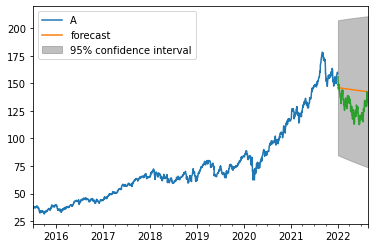

In [7]:
mod = ARIMA(dfclosetrain['A'], order=(1,0,0))
res = mod.fit()
fig, ax = plt.subplots()
dfclosetrain['A'].plot()
plot_predict(res, start=dfclosetest['A'].index[0], end=dfclosetest['A'].index[163], ax=ax)
dfclosetest['A'].plot(ax=ax, label='Actual')
plt.show()

As can be seen above the forecast is a little rigid, it did however correctly predict a downward trend which may or may not be significant. Let's try creating forecasts for other stocks. 

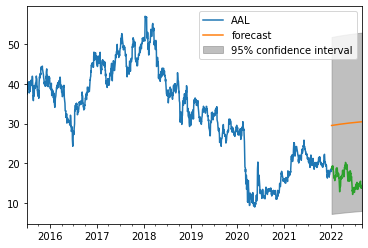

In [8]:
mod = ARIMA(dfclosetrain['AAL'], order=(1,0,0))
res = mod.fit()
fig, ax = plt.subplots()
dfclosetrain['AAL'].plot()
plot_predict(res, start=dfclosetest['A'].index[0], end=dfclosetest['A'].index[163], ax=ax)
dfclosetest['AAL'].plot(ax=ax, label='Actual')
plt.show()

The forcast for our next stock is just completely off here, this most likely means we need to use a different model. Or fine tune our current model. Lets try testing multiple different lag observation values. We also want to set the differencing to one, to line up our forecasts with our actual data.

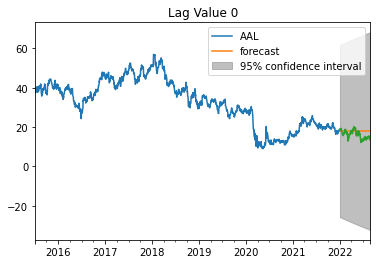

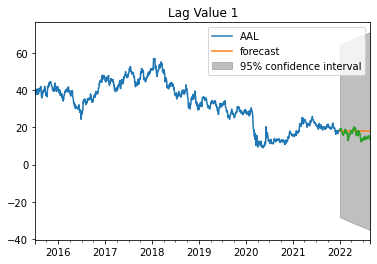

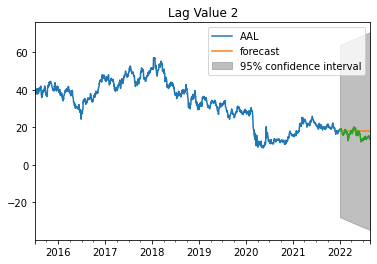

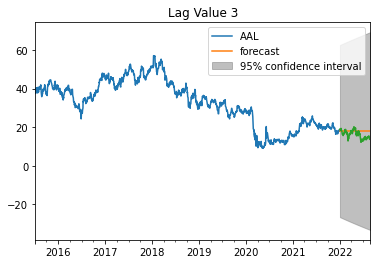

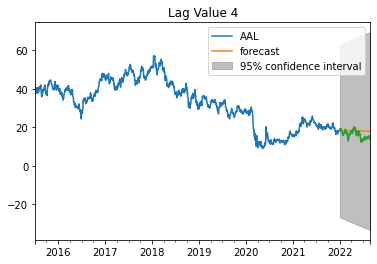

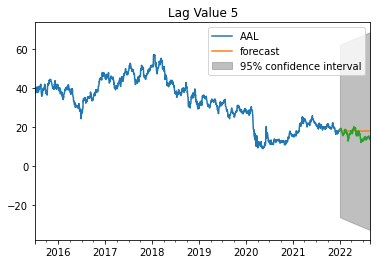

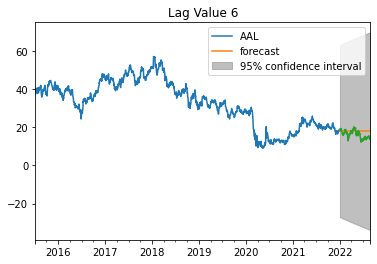

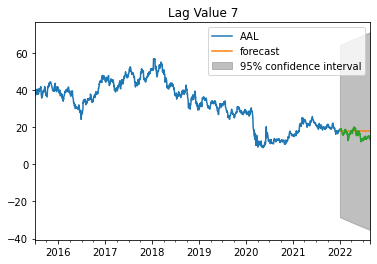

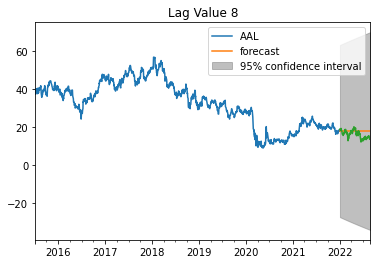

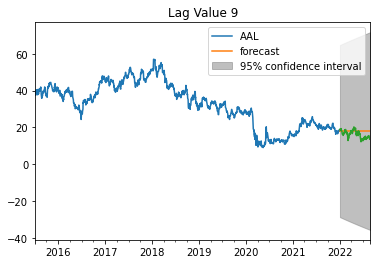

In [9]:
for i in range(10):
    mod = ARIMA(dfclosetrain['AAL'], order=(i,1,0))
    res = mod.fit()
    fig, ax = plt.subplots()
    dfclosetrain['AAL'].plot()
    plot_predict(res, start=dfclosetest['A'].index[0], end=dfclosetest['A'].index[163], ax=ax)
    dfclosetest['AAL'].plot(ax=ax, label='Actual')
    plt.title('Lag Value %i' %i)
    plt.show()

Hmm we still aren't seeing a clear difference between all these values, let's try creating a forward rolling forecast, this will incorporate our previously predicted value into our next prediction.

In [10]:
predictions = list()
AALhist = [x for x in dfclosetrain['AAL']]
for t in range(len(dfclosetest['AAL'])):
 model = ARIMA(AALhist, order=(5,0,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = AALhist[t]
 AALhist.append(obs)

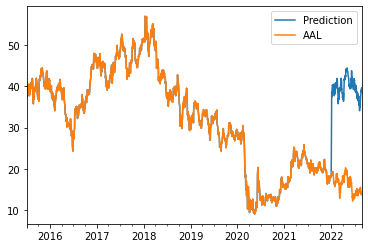

In [11]:
#Lets now plot this data against our predicted values
AALhist = pd.DataFrame(AALhist)
AALhist.index = pd.DatetimeIndex(df.columns.drop('Unnamed: 0')).to_period('D')
AALcomplete = dfclose.T['AAL']
AALcomplete = pd.DataFrame(AALcomplete)
AALcomplete.index = pd.DatetimeIndex(df.columns.drop('Unnamed: 0')).to_period('D')
AALhist.rename({0: 'Prediction'}, axis='columns', inplace=True)
AALhist.rename({0: 'Actual'}, axis='columns', inplace=True)

fig, ax = plt.subplots()
AALhist.plot(ax=ax, label='Prediction')
AALcomplete.plot(ax=ax, label='Actual')
plt.show()

For some odd reason we have a jump in our prediction from around $20, to $40, this is most likely due to the fact our data is putting an even weight across all our data points. Therefore the data from 2015 to 2020 heavily skews our data upward, causing the spike up to 40 in our forecast. Despite this our forecasted data actually very closely follows the trends we observed in real life. Lets see if we can remove this discrepancy from our data by only taking into consideration data from March 2020 onward, this is after the COVID stock market crash, this anomaly is messing with our data greatly.

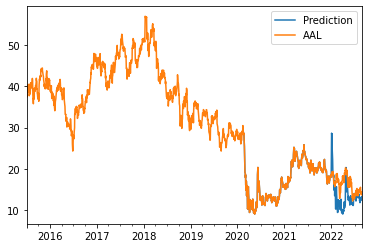

In [12]:
predictions = list()
AALhist = [x for x in dfclosetrain['AAL']]
AALhist = AALhist[-474:]
for t in range(len(dfclosetest['AAL'])):
 model = ARIMA(AALhist, order=(5,0,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = AALhist[t]
 AALhist.append(obs)

AALhist = pd.DataFrame(AALhist)
AALhist.index = pd.DatetimeIndex(df.columns.drop('Unnamed: 0')[-638:]).to_period('D')
AALcomplete = dfclose.T['AAL']
AALcomplete = pd.DataFrame(AALcomplete)
AALcomplete.index = pd.DatetimeIndex(df.columns.drop('Unnamed: 0')).to_period('D')
AALhist.rename({0: 'Prediction'}, axis='columns', inplace=True)
AALcomplete.rename({0: 'Actual'}, axis='columns', inplace=True)

fig, ax = plt.subplots()
AALhist.plot(ax=ax, label='Prediction')
AALcomplete.plot(ax=ax, label='Actual')
plt.show()

Our data still looks irregular, this is likely due to extended volatility that occured in the stock market after the COVID crash. It seems like we are overfitting our data and it might be best to run these models over a shorter timeframe. It might be best to only look at the 2022 data and go over multiple 

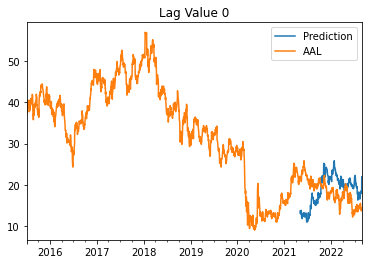

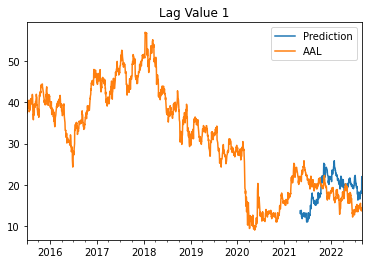

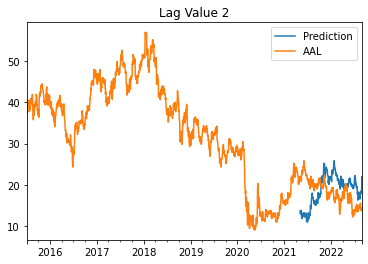

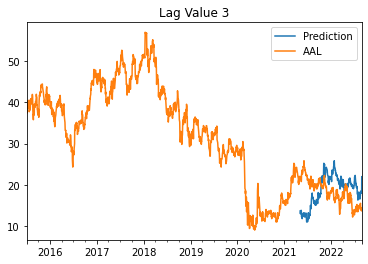

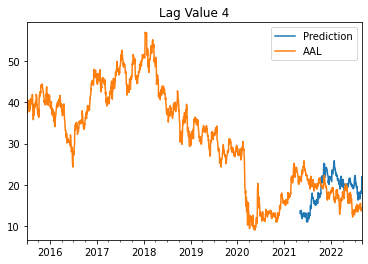

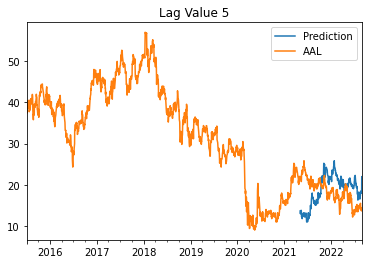

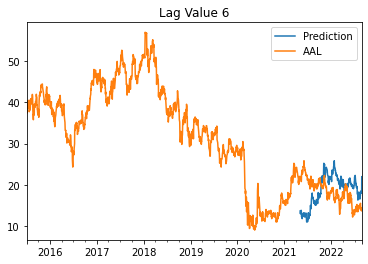

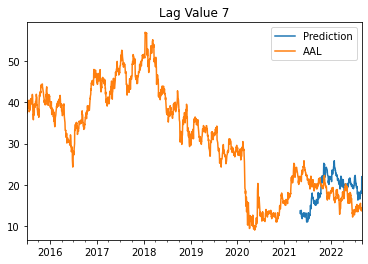

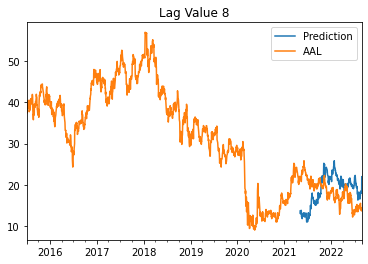

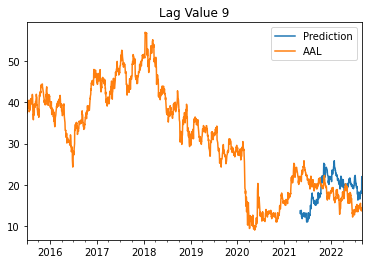

In [4]:
i=0
for i in range(10):
    for t in range(len(dfclosetest['AAL'])):
        predictions = list()
        AALhist = [x for x in dfclosetrain['AAL']]
        AALhist = AALhist[-333:]
        model = ARIMA(AALhist, order=(i,0,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = AALhist[t]
        AALhist.append(obs)
    AALhist = pd.DataFrame(AALhist)
    AALhist.index = pd.DatetimeIndex(df.columns.drop('Unnamed: 0')[-334:]).to_period('D')
    AALcomplete = dfclose.T['AAL']
    AALcomplete = pd.DataFrame(AALcomplete)
    AALcomplete.index = pd.DatetimeIndex(df.columns.drop('Unnamed: 0')).to_period('D')
    AALhist.rename({0: 'Prediction'}, axis='columns', inplace=True)
    AALcomplete.rename({0: 'Actual'}, axis='columns', inplace=True)
    fig, ax = plt.subplots()
    AALhist.plot(ax=ax, label='Prediction')
    AALcomplete.plot(ax=ax, label='Actual')
    plt.title('Lag Value %i' %i)
    plt.show()

## Facebook Prophet Forecasting Model
It seems the ARIMA model isn't really working for what we want, we changed how we input the data and we evened hyperparameter tune our model over different lags, but it seemed to not have any significant effect. Next we will try another model, the Facebook Prophet model, this model is a more complex model, it is a additive linear regression model that incorporates things like seasonality, trends, moving averages, etc. 

In [3]:
from prophet import Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


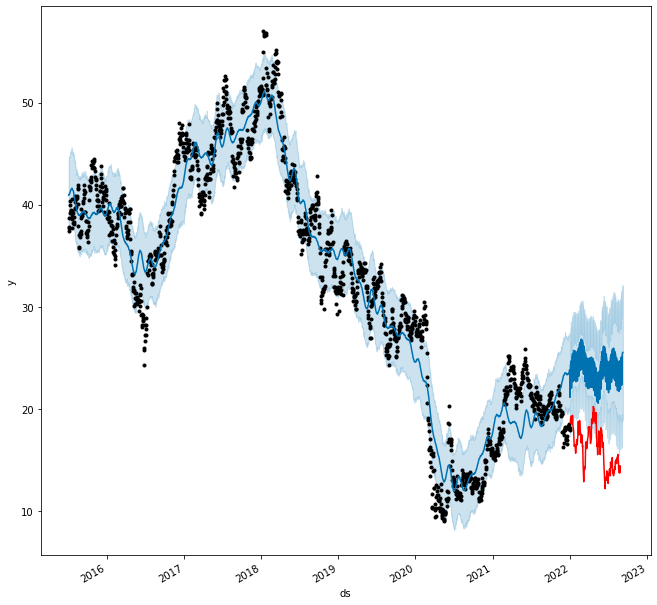

In [4]:
m = Prophet()
prophetdfAAL = pd.DataFrame(dfclosetrain.loc[:,"AAL"])
prophetdfAAL.reset_index(inplace=True)
prophetdfAAL.rename(columns={'index':'ds', 'AAL':'y'}, inplace="True")
prophetdfAAL['ds'] = prophetdfAAL['ds'].dt.to_timestamp()
m.fit(prophetdfAAL)
future = m.make_future_dataframe(periods=251)
forecast = m.predict(future)
fig, ax = plt.subplots()
m.plot(forecast, ax=ax)
dfclosetest.loc[:,"AAL"].plot(ax=ax, color='red', figsize=(10,10))
plt.show()

Facebooks Prophet model looks a lot better, but it does look like we are having the same problem as last time with overfitting data. We can address this by considering seasonality in our model, and we can also begin to hyperparameter tune our model.

In [16]:
from sklearn.model_selection import ParameterGrid

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

prophetdfAALtest = pd.DataFrame(dfclosetest.loc[:,"AAL"])
prophetdfAALtest.reset_index(inplace=True)
prophetdfAALtest.rename(columns={'index':'ds', 'AAL':'y'}, inplace="True")
prophetdfAALtest['ds'] = prophetdfAALtest['ds'].dt.to_timestamp()

params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
strt='2022-01-03'
end='2022-08-26'
for p in grid:
    test = pd.DataFrame()
    print(p)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=False,
                         daily_seasonality = False,
                         yearly_seasonality = True, 
                         interval_width=0.95)
    train_model.fit(prophetdfAAL)
    train_forecast = train_model.make_future_dataframe(periods=164, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = prophetdfAALtest
    MAPE = mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)


{'changepoint_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Mean Absolute Percentage Error(MAPE)------------------------------------ 56.2654407416829
{'changepoint_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 61.85245510673898
{'changepoint_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 57.352994317438686
{'changepoint_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 61.965963613706144
{'changepoint_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 57.27582729925052
{'changepoint_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 62.06269870378329
{'changepoint_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 66.01061981004828
{'changepoint_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 64.96860852257846
{'changepoint_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 66.5644698730321
{'changepoint_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 65.05728550864137
{'changepoint_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 66.18623482044896
{'changepoint_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 65.44359554754887
{'changepoint_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 72.04476696881223
{'changepoint_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 65.40777592723946
{'changepoint_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 72.07304549880081
{'changepoint_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 65.54134965995449
{'changepoint_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 72.61188459046406
{'changepoint_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 65.77325847285974
{'changepoint_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 74.26137337268625
{'changepoint_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 65.76251257592614
{'changepoint_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 74.31854390816159
{'changepoint_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 66.00445009199201
{'changepoint_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 74.54241491680868
{'changepoint_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 66.09849248342343
{'changepoint_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 74.78045768478732
{'changepoint_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 65.89144771121505
{'changepoint_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 74.94556054346126
{'changepoint_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 66.0876888444263
{'changepoint_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 74.76639379377696
{'changepoint_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = componen

Mean Absolute Percentage Error(MAPE)------------------------------------ 66.45195678776477


C:\Users\JB\AppData\Local\Temp\ipykernel_71824\2430317511.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)


In [20]:
model_parameters.sort_values(by='MAPE')

,MAPE,Parameters
0,56.265441,"{'changepoint_prior_scale': 0.1, 'n_changepoin..."
4,57.275827,"{'changepoint_prior_scale': 0.1, 'n_changepoin..."
2,57.352994,"{'changepoint_prior_scale': 0.1, 'n_changepoin..."
1,61.852455,"{'changepoint_prior_scale': 0.1, 'n_changepoin..."
3,61.965964,"{'changepoint_prior_scale': 0.1, 'n_changepoin..."
5,62.062699,"{'changepoint_prior_scale': 0.1, 'n_changepoin..."
7,64.968609,"{'changepoint_prior_scale': 0.2, 'n_changepoin..."
9,65.057286,"{'changepoint_prior_scale': 0.2, 'n_changepoin..."
13,65.407776,"{'changepoint_prior_scale': 0.3, 'n_changepoin..."
11,65.443596,"{'changepoint_prior_scale': 0.2, 'n_changepoin..."


So from running our GridSearch of Prophet, we found that the very first model we tested was the one with the lowest Mean Absolute Percentage Error. Using this we can create our model based off those parameters and find the most accurate forecast.

In [32]:
print(model_parameters['Parameters'][0])

{'changepoint_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


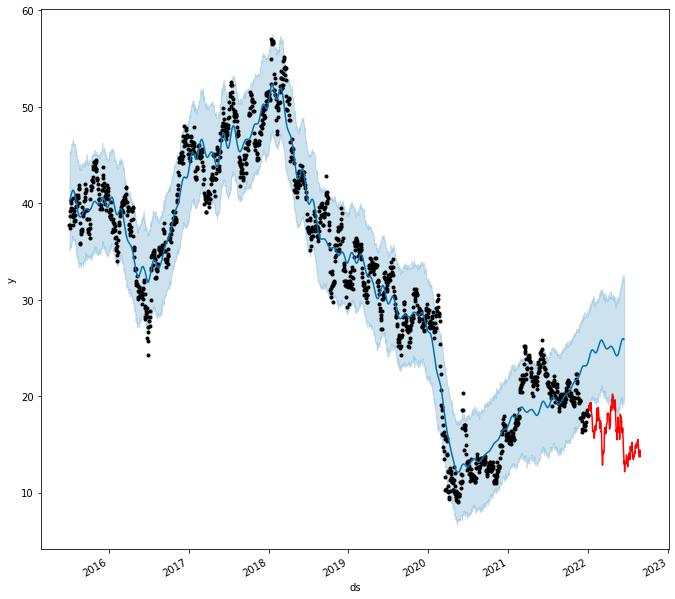

In [36]:
m = Prophet(changepoint_prior_scale = 0.1,
                         n_changepoints = 100,
                         seasonality_mode = 'multiplicative',
                         weekly_seasonality=False,
                         daily_seasonality = False,
                         yearly_seasonality = True, 
                         interval_width=0.95)
m.fit(prophetdfAAL)
future = m.make_future_dataframe(periods=164)
forecast = m.predict(future)
fig, ax = plt.subplots()
m.plot(forecast, ax=ax)
dfclosetest.loc[:,"AAL"].plot(ax=ax, color='red', figsize=(10,10))
plt.show()

The Prophet model seems to predicting an upward trend, this is most likely from overfitting our data, let's try to decrease the amount of data we are inputting into our model and see if the helps with our forecasting.

C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\JB\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


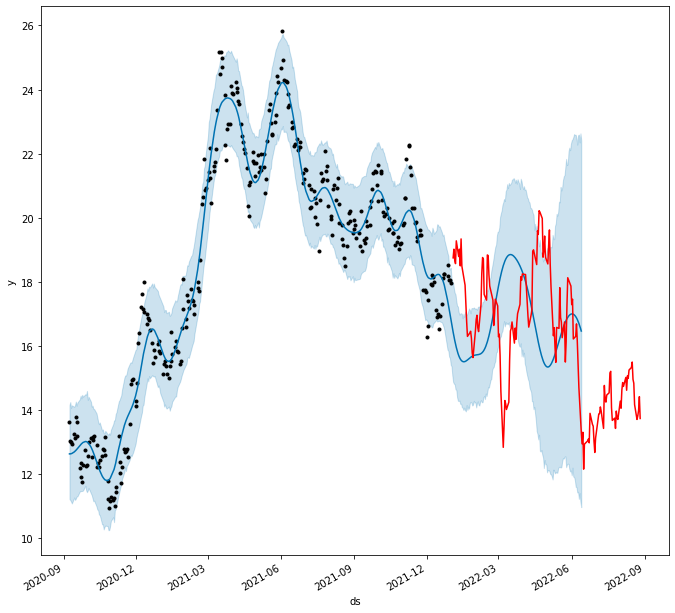

In [44]:
prophetdfAALreduced = prophetdfAAL[-333:]
m = Prophet(changepoint_prior_scale = 0.1,
                         n_changepoints = 100,
                         seasonality_mode = 'multiplicative',
                         weekly_seasonality=False,
                         daily_seasonality = False,
                         yearly_seasonality = True, 
                         interval_width=0.95)
m.fit(prophetdfAALreduced)
future = m.make_future_dataframe(periods=164)
forecast = m.predict(future)
fig, ax = plt.subplots()
m.plot(forecast, ax=ax)
dfclosetest.loc[:,"AAL"].plot(ax=ax, color='red', figsize=(10,10))
plt.show()

This looks a lot better, it seems it makes more sense to forecast data over shorter periods of times, and to not to overfit our data. This is likely due to the volatile nature of the stock market and how unpredictable things can get in the world. If you look at the graph you see a sharp decline in the value of the stock around March 2022, this was due to the fact that the federal government started hiking interest rates, something that can't be predicted with a model that only looks at trends in the price of stocks. Price forecasting is most likely to be more reliable in daily price fluctations, not price fluctuations over a long period of time.